
# Philippine House Hold Income
### Group: Life 4
### Project Duration: March 15, 2021 to March __, 2021

Life is a gift and we need to live it fully, for we only have one shot at life. In life, we are given the chance to go through ups and downs, and learn & grow as we experience them.

In order to keep living, we need a safety, security, and well-being. This is where our **income** comes in. By having a source of income, we can survive our day to day living, and acquire safety, security, and well-being, by being able to provide for our families with their daily needs. Although we can say that this is just the bare minimum, it is safe to say that income is very important.

This project aims to predict the total household income of a family per region in the Philippines, with the help of multiple predictor variables. There are two datasets used for this project. The first one is **Filipino Family Income and Expenditure** which contains data of the annual household income and expenses in the Philippines, and can be found [here](https://www.kaggle.com/grosvenpaul/family-income-and-expenditure), and the second is **TESDA (Technical Education and Skills Development Authority) Institutions** which contains a list of technical vocational institutions with TESDA registered programs and can be found [here](https://data.gov.ph/?q=dataset/list-technical-vocational-institutions-tesda-registered-programs).

This Data Analytics project is created by the following group of 3rd year college students from Cebu Institute of Technology - University: Princess Eramie Arenas, Carl Cordova, Diane Isabelle Lambojo, Penelope Joice Lapiz, and Cary Legaspi.

### Importing Libraries

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor # multi layer perceptron
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

import math

### Defining Functions

In [39]:
def extract_tesda_data():
    tesda_df = pd.read_csv('tesda_institutions.csv')
    tesda_df = tesda_df.drop_duplicates(subset='name_of_institution')
    tesda_df = tesda_df.region.value_counts().reset_index(name='tesda_accredited_institutions')
    tesda_df = tesda_df.rename(columns={'index':'region'})
    return tesda_df

def format_regions(income_df):
    income_df['region'] = income_df['region'].replace('Caraga', 'CARAGA')
    income_df['region'] = income_df['region'].replace('VI - Western Visayas', 'VI')
    income_df['region'] = income_df['region'].replace('V - Bicol Region', 'V')
    income_df['region'] = income_df['region'].replace(' ARMM', 'ARMM')
    income_df['region'] = income_df['region'].replace('III - Central Luzon', 'III')
    income_df['region'] = income_df['region'].replace('II - Cagayan Valley', 'II')
    income_df['region'] = income_df['region'].replace('IVA - CALABARZON', 'IV-A')
    income_df['region'] = income_df['region'].replace('VII - Central Visayas', 'VII')
    income_df['region'] = income_df['region'].replace('X - Northern Mindanao', 'X')
    income_df['region'] = income_df['region'].replace('XI - Davao Region', 'XI')
    income_df['region'] = income_df['region'].replace('VIII - Eastern Visayas', 'VIII')
    income_df['region'] = income_df['region'].replace('I - Ilocos Region', 'I')
    income_df['region'] = income_df['region'].replace('IVB - MIMAROPA', 'IV-B')
    income_df['region'] = income_df['region'].replace('XII - SOCCSKSARGEN', 'XII')
    income_df['region'] = income_df['region'].replace('IX - Zasmboanga Peninsula', 'IX')
    return income_df

def check_null(income_df):
    income_df = income_df.isnull().sum()
    return income_df

def replace_nan(income_df):
    income_df = income_df.replace('..','nan')
    income_df.sample(10)
    return income_df

def replace_inf(income_df):
    income_df = income_df.replace([np.inf, -np.inf], np.nan).dropna(how="all")
    return income_df

def check_dupes(income_df):
    income_df = income_df.duplicated()
    return income_df

def check_shape(income_df):
    income_df = income_df.shape
    return income_df

def format_categorical_columns(income_df):
    #main income source column
    income_df['main_income_source'] = income_df['main_income_source'].replace('Wage/Salaries', 'wage_salaries')
    income_df['main_income_source'] = income_df['main_income_source'].replace('Other sources of Income', 'other_source_of_income')
    income_df['main_income_source'] = income_df['main_income_source'].replace('Enterpreneurial Activities', 'entrep_activities')
    #house hold sex column
    income_df['house_hold_sex'] = income_df['house_hold_sex'].replace('Female', 'female')
    income_df['house_hold_sex'] = income_df['house_hold_sex'].replace('Male', 'male')
    #househould head marital status column
    income_df['house_hold_head_marital_status'] = income_df['house_hold_head_marital_status'].replace('Single', 'single')
    income_df['house_hold_head_marital_status'] = income_df['house_hold_head_marital_status'].replace('Married', 'married')
    income_df['house_hold_head_marital_status'] = income_df['house_hold_head_marital_status'].replace('Widowed', 'widowed')
    income_df['house_hold_head_marital_status'] = income_df['house_hold_head_marital_status'].replace('Divorced/Separated', 'divorced_separated')
    income_df['house_hold_head_marital_status'] = income_df['house_hold_head_marital_status'].replace('Annulled', 'annulled')
    income_df['house_hold_head_marital_status'] = income_df['house_hold_head_marital_status'].replace('Unknown', 'unknown')
    #househould head job/business indicator column
    income_df['household_head_job_business_indicator'] = income_df['household_head_job_business_indicator'].replace('With Job/Business', 'with_job_business')
    income_df['household_head_job_business_indicator'] = income_df['household_head_job_business_indicator'].replace('No Job/Business', 'no_job_business')
    #househould type column
    income_df['type_of_household'] = income_df['type_of_household'].replace('Extended Family', 'extended_fam')
    income_df['type_of_household'] = income_df['type_of_household'].replace('Single Family', 'single_fam')
    income_df['type_of_household'] = income_df['type_of_household'].replace('Two or More Nonrelated Persons/Members', 'two_more_nonrelated')
    #househould head worker class column
    income_df['household_head_worker_class'] = income_df['household_head_worker_class'].replace('Worked for government/government corporation', 'worked_for_govt')
    income_df['household_head_worker_class'] = income_df['household_head_worker_class'].replace('Worked for private establishment', 'worked_for_private')
    income_df['household_head_worker_class'] = income_df['household_head_worker_class'].replace('Employer in own family-operated farm or business', 'employer_in_own_fam_business')
    income_df['household_head_worker_class'] = income_df['household_head_worker_class'].replace('Self-employed wihout any employee', 'self_employed_without_employee')
    income_df['household_head_worker_class'] = income_df['household_head_worker_class'].replace('Worked without pay in own family-operated farm or business', 'without_pay_in_own_business')
    income_df['household_head_worker_class'] = income_df['household_head_worker_class'].replace('Worked for private household', 'worked_for_private_household')
    income_df['household_head_worker_class'] = income_df['household_head_worker_class'].replace('Worked with pay in own family-operated farm or business', 'with_pay_in_own_business')
    #tenure status column
    income_df['tenure_status'] = income_df['tenure_status'].replace('Own or owner-like possession of house and lot', 'owner_house_and_lot')
    income_df['tenure_status'] = income_df['tenure_status'].replace('Rent-free house and lot with consent of owner', 'rent_free_house_lot_with_consent')
    income_df['tenure_status'] = income_df['tenure_status'].replace('Own house, rent-free lot with consent of owner', 'own_house_rent_free_lot_with_consent')
    income_df['tenure_status'] = income_df['tenure_status'].replace('Own house, rent-free lot without consent of owner', 'own_house_rent_free_lot_without_consent')
    income_df['tenure_status'] = income_df['tenure_status'].replace('Rent-free house and lot without consent of owner', 'rent_free_house_lot_without_consent')
    income_df['tenure_status'] = income_df['tenure_status'].replace('Rent house/room including lot', 'rent_house_with_lot')
    income_df['tenure_status'] = income_df['tenure_status'].replace('Not Applicable', 'not_applicable')
    income_df['tenure_status'] = income_df['tenure_status'].replace('Own house, rent lot', 'own_house_rent_lot')
    
    return income_df

def encoded_categorical_columns(income_df):
    #one hot encoding
    encoded_income_df = pd.get_dummies(income_df, columns = categorical_columns, prefix = categorical_prefixes, drop_first=True)
    #drop_first=True Remove first level to get k-1 dummies out of k categorical levels. It helps in reducing the extra column created during dummy variable creation. 
    return encoded_income_df

## Preparing the Dataset

Note that not all data will be used from the dataset, and below is the code showing the extraction of useful data for the prediction of income from the tesda_institutions.csv dataset. We decided that in order to improve the r-squared of our models we will add another column to the income and expenditure dataset using the number TESDA accreddited institutions per region.

In [40]:
#Load datasets
tesda_df = extract_tesda_data()
income_df = pd.read_csv('family_income_expenditure.csv')

### Cleaning the TESDA dataframe Income and Expenditure dataframe's region column for merging
The column containing the regions from the **TESDA** dataset is extracted and since some region values has space, it will be replaced for uniformity.On the other hand, the **Filipino Family Income and Expenditure** dataset's naming convention of the regions are not exactly the same as that of the tesda dataset. So we will call format regions to uniformize the region values.
<br><br>

Once the region values are cleaned, both dataframe will be merged on the column **region**. The column tesda_accredited_institutions will be added to income_df.

In [41]:
#format the region to be the same with tesda region column so that they can be merged
format_regions(income_df)
tesda_df['region'] = tesda_df['region'].replace('IX ', 'IX')
print(sorted(income_df.region.unique()))
print(sorted(tesda_df.region.unique()))

['ARMM', 'CAR', 'CARAGA', 'I', 'II', 'III', 'IV-A', 'IV-B', 'IX', 'NCR', 'V', 'VI', 'VII', 'VIII', 'X', 'XI', 'XII']
['ARMM', 'CAR', 'CARAGA', 'I', 'II', 'III', 'IV-A', 'IV-B', 'IX', 'NCR', 'V', 'VI', 'VII', 'VIII', 'X', 'XI', 'XII']


All is good, we will now **merge** both dataframes.

In [42]:
#merge tesda and income_expenditure df
income_df = pd.merge(income_df, tesda_df, on='region')

## Exploring the Dataset

To explore the dataset, we will create a scatter plot diagram. Since this have 60 columns, we will only select columns that have possible correlation with total household income based on the scatterplot and is considered as interesting when interpreted based on the models for the dataset.

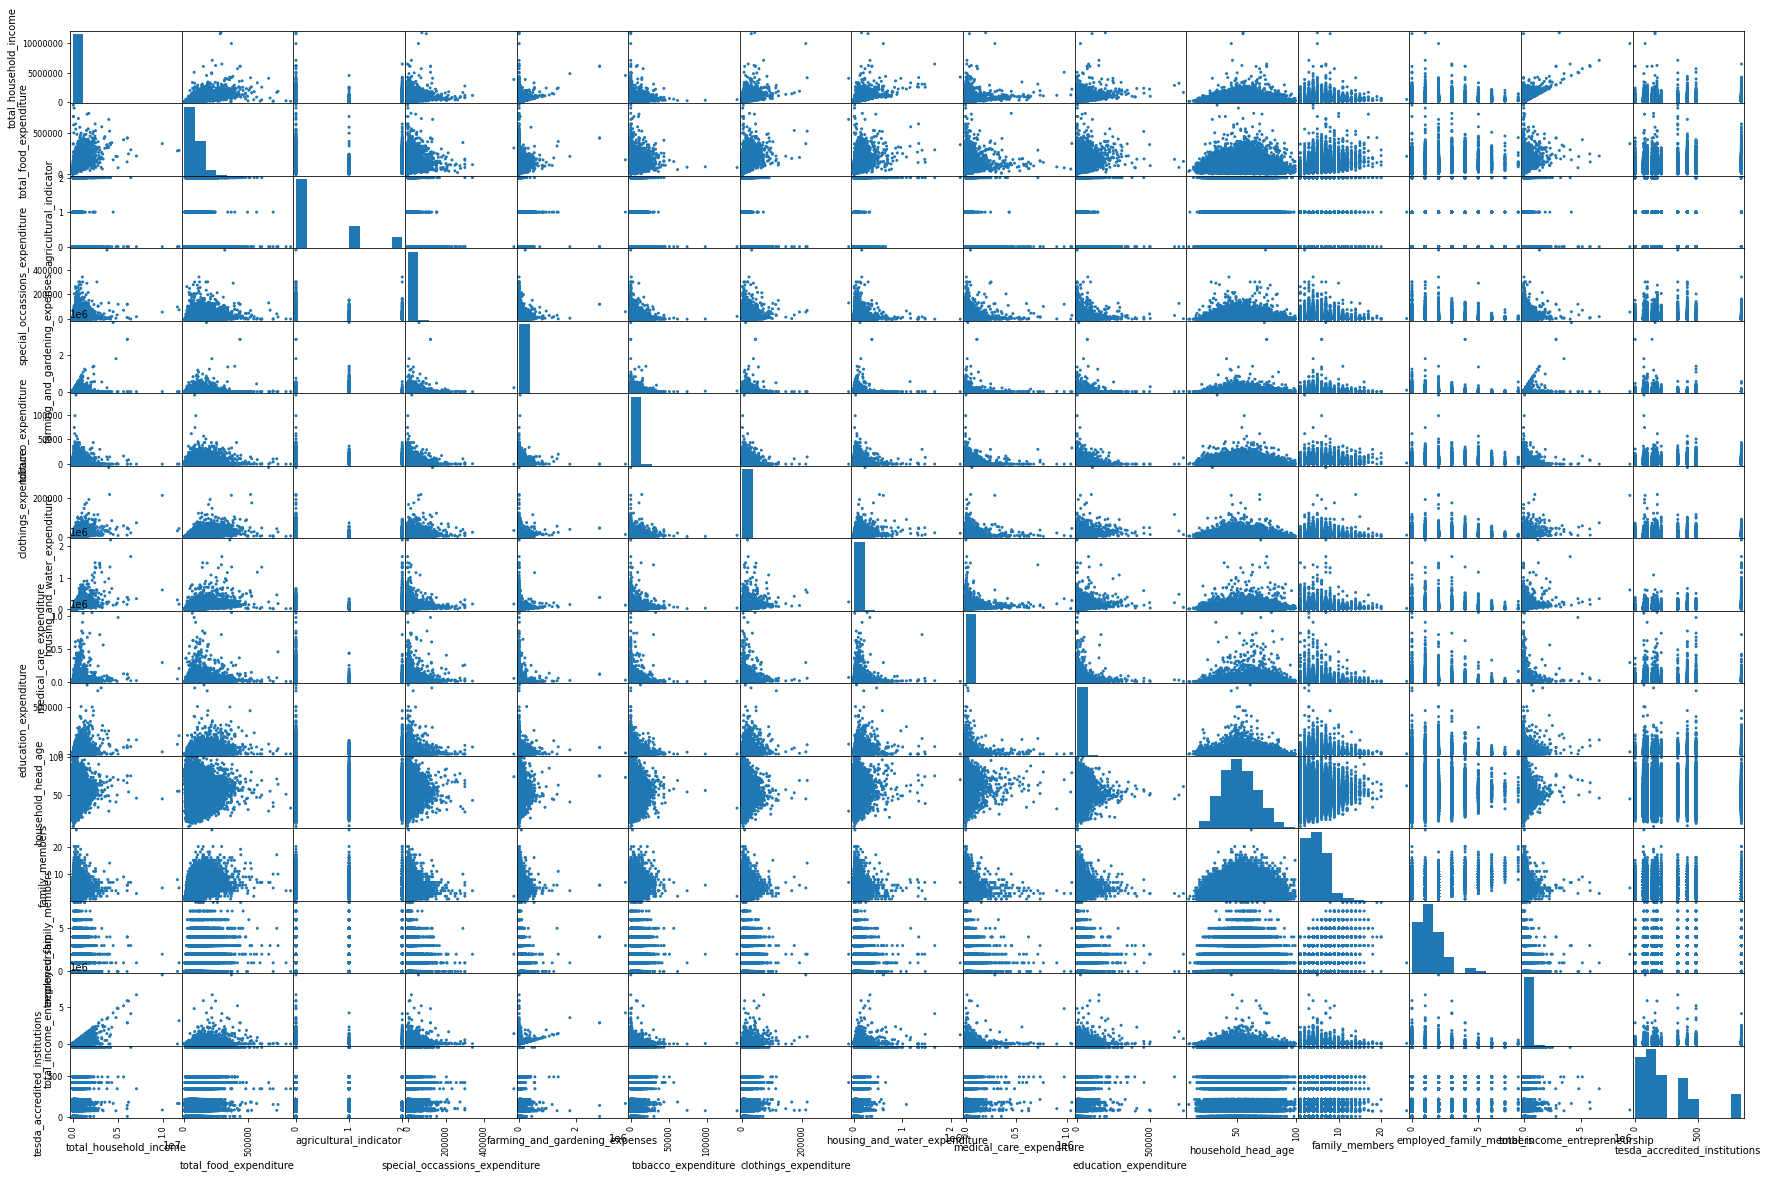

In [16]:
pd.plotting.scatter_matrix(income_df, alpha = 1, figsize = (30, 20))
plt.show()

## Variables

#### TODO: Add definitions for added variables
Based on the scatterplot and judgement of the authors, the following are the variables used for this project:<br><br>
**y = total_household_income** - the total annual income the household earns <br>
**x1 = region** - the location of the household <br>
**x2 = total_food_expenditure** - the total expense a household spends for food consumption <br>
**x3 = main_income_source** - the household's main source of income <br>
**x4 = agricultural_indicator**<br>
**x5 = tobacco_expenditure** - the total expense a household spends for tobacco usage<br>
**x6 = clothings_expenditure** - the total expense a household spends for clothing <br>
**x7 = housing_and_water_expenditure** - the total expense a household spends for housing and water bills <br>
**x8 = medical_care_expenditure** - the total expense a household spends for health/medical care<br>
**x9 = education_expenditure** - the total expense a household spends for education <br>
**x10 = house_hold_sex** - the gender of the household head <br>
**x11 = household_head_age** - the age of the household head <br>
**x12 = house_hold_head_marital_status** - the marital status of the household head <br>
**x13 = household_head_highest_grade** - the highest educational attainment of the household head <br>
**x14 = household_head_job_business_indicator** - the identification whether the household head has a job or a business <br>
**x15 = type_of_household** - the type of family/families living in a household <br>
**x16 = family_members** - the total number of family members in a household <br>
**x17 = employed_family_members** - the total number of employed family members in a household <br>
**x18 = tesda_accredited_institutions** - the total number of tesda accredited institutions per region <br>

In [43]:
#columns that will be used
column_names = [
    'total_household_income',
    'region',
    'total_food_expenditure',
    'main_income_source',
    'agricultural_indicator',
    'special_occassions_expenditure',
    'farming_and_gardening_expenses',
    'tobacco_expenditure',
    'clothings_expenditure',
    'housing_and_water_expenditure',
    'medical_care_expenditure',
    'education_expenditure',
    'house_hold_sex',
    'household_head_age',
    'house_hold_head_marital_status',
    'household_head_job_business_indicator',
    'type_of_household',
    'family_members',
    'employed_family_members',
    'total_income_entrepreneurship',
    'household_head_worker_class',
    'tenure_status',
    'tesda_accredited_institutions', 
]
#identifying categorical columns for encoding
categorical_columns = [
    'region',
    'main_income_source',
    'house_hold_sex',
    'house_hold_head_marital_status',
    'household_head_job_business_indicator',
    'type_of_household',
    'household_head_worker_class',
    'tenure_status',
]
categorical_prefixes = [
    'region',
    'income_source',
    'head_sex',
    'head',
    'head_indicator',
    'household_type',
    'worker_class',
    'tenure'
]

In [44]:
### Selecting the Columns
income_df = income_df[column_names]

## Removing Outliers ??
In order to improve r-squared score, we decided to remove the outliers.

First, we c the summary and added a column for the +-3 standard deviations.

In [45]:
# get the summary
desc_df = income_df.describe()

# add the standard deviation metric
desc_df.loc['+3_std'] = desc_df.loc['mean'] + (desc_df.loc['std'] * 3)
desc_df.loc['-3_std'] = desc_df.loc['mean'] - (desc_df.loc['std'] * 3)

# display it
desc_df

,total_household_income,total_food_expenditure,agricultural_indicator,special_occassions_expenditure,farming_and_gardening_expenses,tobacco_expenditure,clothings_expenditure,housing_and_water_expenditure,medical_care_expenditure,education_expenditure,household_head_age,family_members,employed_family_members,total_income_entrepreneurship,tesda_accredited_institutions
count,4.333200e+04,43332.000000,43332.000000,43332.000000,4.333200e+04,43332.000000,43332.000000,4.333200e+04,4.333200e+04,43332.000000,43332.000000,43332.000000,43332.000000,4.333200e+04,43332.000000
mean,2.452220e+05,84461.489361,0.434252,5224.179936,1.386299e+04,2270.874227,4932.328395,3.765405e+04,7.036667e+03,7349.083795,51.363542,4.631750,1.266016,5.419615e+04,263.286878
std,2.852569e+05,51453.254209,0.677917,13179.403703,4.888766e+04,3959.229048,7456.143621,5.237894e+04,2.655895e+04,20939.689536,14.156461,2.276612,1.143029,1.455832e+05,231.787573
min,1.128500e+04,2947.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.950000e+03,0.000000e+00,0.000000,9.000000,1.000000,0.000000,0.000000e+00,5.000000
25%,1.039888e+05,50463.000000,0.000000,0.000000,0.000000e+00,0.000000,1365.000000,1.275000e+04,2.990000e+02,0.000000,41.000000,3.000000,0.000000,0.000000e+00,100.000000
50%,1.622870e+05,72367.000000,0.000000,1500.000000,0.000000e+00,310.000000,2720.500000,2.241600e+04,1.101000e+03,870.000000,51.000000,4.000000,1.000000,1.981350e+04,172.000000
75%,2.880710e+05,105031.750000,1.000000,5000.000000,7.140000e+03,3120.000000,5530.500000,4.501350e+04,4.538250e+03,4000.000000,61.000000,6.000000,2.000000,6.586650e+04,419.000000
max,1.181599e+07,827565.000000,2.000000,556700.000000,3.729973e+06,139370.000000,356750.000000,2.188560e+06,1.049275e+06,731000.000000,99.000000,26.000000,8.000000,9.234485e+06,848.000000
+3_std,1.100993e+06,238821.251989,2.468002,44762.391046,1.605260e+05,14148.561372,27300.759259,1.947909e+05,8.671352e+04,70168.152401,93.832926,11.461585,4.695104,4.909456e+05,958.649598
-3_std,-6.105486e+05,-69898.273266,-1.599499,-34314.031174,-1.328000e+05,-9606.812918,-17436.102469,-1.194828e+05,-7.264019e+04,-55469.984812,8.894158,-2.198084,-2.163072,-3.825533e+05,-432.075842


#### Loop through all columns and remove rows that are beyond +3 and -3 standard deviations

In [46]:
# filter the data frame to remove the values exceeding 3 standard deviations
for i in list(set(column_names) - set(categorical_columns)):
    income_df = income_df[(np.abs(stats.zscore(income_df[i])) < 3)]

## Data Cleaning

In [47]:
#checking for nulls
check_null(income_df)

total_household_income                      0
region                                      0
total_food_expenditure                      0
main_income_source                          0
agricultural_indicator                      0
special_occassions_expenditure              0
farming_and_gardening_expenses              0
tobacco_expenditure                         0
clothings_expenditure                       0
housing_and_water_expenditure               0
medical_care_expenditure                    0
education_expenditure                       0
house_hold_sex                              0
household_head_age                          0
house_hold_head_marital_status              0
household_head_job_business_indicator       0
type_of_household                           0
family_members                              0
employed_family_members                     0
total_income_entrepreneurship               0
household_head_worker_class              6143
tenure_status                     

In [48]:
#replacing nan values
replace_nan(income_df)

,total_household_income,region,total_food_expenditure,main_income_source,agricultural_indicator,special_occassions_expenditure,farming_and_gardening_expenses,tobacco_expenditure,clothings_expenditure,housing_and_water_expenditure,...,household_head_age,house_hold_head_marital_status,household_head_job_business_indicator,type_of_household,family_members,employed_family_members,total_income_entrepreneurship,household_head_worker_class,tenure_status,tesda_accredited_institutions
0,480332,CAR,117848,Wage/Salaries,0,7200,19370,0,4607,63636,...,49,Single,With Job/Business,Extended Family,4,1,44370,Worked for government/government corporation,Own or owner-like possession of house and lot,100
1,198235,CAR,67766,Wage/Salaries,0,1500,0,2132,8230,41370,...,40,Married,With Job/Business,Single Family,3,2,0,Worked for private establishment,Own or owner-like possession of house and lot,100
2,82785,CAR,61609,Wage/Salaries,1,500,0,4525,2735,14340,...,39,Married,With Job/Business,Single Family,6,3,0,Worked for private establishment,Own or owner-like possession of house and lot,100
3,107589,CAR,78189,Wage/Salaries,0,500,15580,0,1390,16638,...,52,Married,With Job/Business,Single Family,3,2,15580,Employer in own family-operated farm or business,Own or owner-like possession of house and lot,100
4,189322,CAR,94625,Wage/Salaries,0,1000,18887,0,4620,31122,...,65,Married,With Job/Business,Single Family,4,2,75687,Self-employed wihout any employee,Own or owner-like possession of house and lot,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43323,163444,IX,80172,Enterpreneurial Activities,2,0,67544,0,5000,18948,...,62,Married,With Job/Business,Extended Family,6,0,127544,Employer in own family-operated farm or business,"Own house, rent-free lot with consent of owner",5
43324,203560,IX,82482,Wage/Salaries,2,0,0,1170,2155,19260,...,55,Married,With Job/Business,Single Family,5,2,48000,Worked for private establishment,Rent-free house and lot with consent of owner,139
43325,203560,IX,82482,Wage/Salaries,2,0,0,1170,2155,19260,...,55,Married,With Job/Business,Single Family,5,2,48000,Worked for private establishment,Rent-free house and lot with consent of owner,5
43330,205590,IX,83441,Other sources of Income,2,2600,0,0,5090,29208,...,42,Single,With Job/Business,Extended Family,5,0,72500,Self-employed wihout any employee,Own or owner-like possession of house and lot,139


In [49]:
#replacing infinity values
replace_inf(income_df)

,total_household_income,region,total_food_expenditure,main_income_source,agricultural_indicator,special_occassions_expenditure,farming_and_gardening_expenses,tobacco_expenditure,clothings_expenditure,housing_and_water_expenditure,...,household_head_age,house_hold_head_marital_status,household_head_job_business_indicator,type_of_household,family_members,employed_family_members,total_income_entrepreneurship,household_head_worker_class,tenure_status,tesda_accredited_institutions
0,480332,CAR,117848,Wage/Salaries,0,7200,19370,0,4607,63636,...,49,Single,With Job/Business,Extended Family,4,1,44370,Worked for government/government corporation,Own or owner-like possession of house and lot,100
1,198235,CAR,67766,Wage/Salaries,0,1500,0,2132,8230,41370,...,40,Married,With Job/Business,Single Family,3,2,0,Worked for private establishment,Own or owner-like possession of house and lot,100
2,82785,CAR,61609,Wage/Salaries,1,500,0,4525,2735,14340,...,39,Married,With Job/Business,Single Family,6,3,0,Worked for private establishment,Own or owner-like possession of house and lot,100
3,107589,CAR,78189,Wage/Salaries,0,500,15580,0,1390,16638,...,52,Married,With Job/Business,Single Family,3,2,15580,Employer in own family-operated farm or business,Own or owner-like possession of house and lot,100
4,189322,CAR,94625,Wage/Salaries,0,1000,18887,0,4620,31122,...,65,Married,With Job/Business,Single Family,4,2,75687,Self-employed wihout any employee,Own or owner-like possession of house and lot,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43323,163444,IX,80172,Enterpreneurial Activities,2,0,67544,0,5000,18948,...,62,Married,With Job/Business,Extended Family,6,0,127544,Employer in own family-operated farm or business,"Own house, rent-free lot with consent of owner",5
43324,203560,IX,82482,Wage/Salaries,2,0,0,1170,2155,19260,...,55,Married,With Job/Business,Single Family,5,2,48000,Worked for private establishment,Rent-free house and lot with consent of owner,139
43325,203560,IX,82482,Wage/Salaries,2,0,0,1170,2155,19260,...,55,Married,With Job/Business,Single Family,5,2,48000,Worked for private establishment,Rent-free house and lot with consent of owner,5
43330,205590,IX,83441,Other sources of Income,2,2600,0,0,5090,29208,...,42,Single,With Job/Business,Extended Family,5,0,72500,Self-employed wihout any employee,Own or owner-like possession of house and lot,139


In [50]:
#checking for duplicates
check_dupes(income_df)

0        False
1        False
2        False
3        False
4        False
         ...  
43323    False
43324    False
43325    False
43330    False
43331    False
Length: 35534, dtype: bool

In [51]:
check_dupes(income_df).sum()

0

In [52]:
#checking shape
check_shape(income_df)

(35534, 23)

### Encoding the Categorical Variables
In order for the different algorithms that will be used in the following section to **run without errors**, we will need to deal with the string values. To do this, we decided to use one hot encoding technique.

#### Loop through all categorical columns and display the unique values

### TODO: clean the categorical values using replace method, get rid of capitalized letters and spaces. should be shorted (as long as it is still readable) and replaced with underscore (_), deal with dummy variables?

In [66]:
for col in income_df:
    if col in categorical_columns:
        print('For '+col+': ',income_df[col].unique())

For region:  ['CAR' 'CARAGA' 'VI' 'V' 'ARMM' 'III' 'II' 'IV-A' 'VII' 'X' 'XI' 'VIII'
 'I' 'NCR' 'IV-B' 'XII' 'IX']
For main_income_source:  ['wage_salaries' 'other_source_of_income' 'entrep_activities']
For house_hold_sex:  ['female' 'male']
For house_hold_head_marital_status:  ['single' 'married' 'widowed' 'divorced_separated' 'annulled' 'unknown']
For household_head_job_business_indicator:  ['with_job_business' 'no_job_business']
For type_of_household:  ['extended_fam' 'single_fam' 'two_more_nonrelated']
For household_head_worker_class:  ['worked_for_govt' 'worked_for_private' 'employer_in_own_fam_business'
 'self_employed_without_employee' nan 'without_pay_in_own_business'
 'worked_for_private_household' 'with_pay_in_own_business']
For tenure_status:  ['owner_house_and_lot' 'rent_free_house_lot_with_consent'
 'own_house_rent_free_lot_with_consent'
 'own_house_rent_free_lot_without_consent'
 'rent_free_house_lot_without_consent' 'rent_house_with_lot'
 'not_applicable' 'own_house_rent

### Format categorical columns

In [54]:
format_categorical_columns(income_df) 

,total_household_income,region,total_food_expenditure,main_income_source,agricultural_indicator,special_occassions_expenditure,farming_and_gardening_expenses,tobacco_expenditure,clothings_expenditure,housing_and_water_expenditure,...,household_head_age,house_hold_head_marital_status,household_head_job_business_indicator,type_of_household,family_members,employed_family_members,total_income_entrepreneurship,household_head_worker_class,tenure_status,tesda_accredited_institutions
0,480332,CAR,117848,wage_salaries,0,7200,19370,0,4607,63636,...,49,single,with_job_business,extended_fam,4,1,44370,worked_for_govt,owner_house_and_lot,100
1,198235,CAR,67766,wage_salaries,0,1500,0,2132,8230,41370,...,40,married,with_job_business,single_fam,3,2,0,worked_for_private,owner_house_and_lot,100
2,82785,CAR,61609,wage_salaries,1,500,0,4525,2735,14340,...,39,married,with_job_business,single_fam,6,3,0,worked_for_private,owner_house_and_lot,100
3,107589,CAR,78189,wage_salaries,0,500,15580,0,1390,16638,...,52,married,with_job_business,single_fam,3,2,15580,employer_in_own_fam_business,owner_house_and_lot,100
4,189322,CAR,94625,wage_salaries,0,1000,18887,0,4620,31122,...,65,married,with_job_business,single_fam,4,2,75687,self_employed_without_employee,owner_house_and_lot,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43323,163444,IX,80172,entrep_activities,2,0,67544,0,5000,18948,...,62,married,with_job_business,extended_fam,6,0,127544,employer_in_own_fam_business,own_house_rent_free_lot_with_consent,5
43324,203560,IX,82482,wage_salaries,2,0,0,1170,2155,19260,...,55,married,with_job_business,single_fam,5,2,48000,worked_for_private,rent_free_house_lot_with_consent,139
43325,203560,IX,82482,wage_salaries,2,0,0,1170,2155,19260,...,55,married,with_job_business,single_fam,5,2,48000,worked_for_private,rent_free_house_lot_with_consent,5
43330,205590,IX,83441,other_source_of_income,2,2600,0,0,5090,29208,...,42,single,with_job_business,extended_fam,5,0,72500,self_employed_without_employee,owner_house_and_lot,139


### Encoded categorical columns

In [55]:
encoded_categorical_columns(income_df) #the function already deals with dummy variable to avoid dummy variable trap

,total_household_income,total_food_expenditure,agricultural_indicator,special_occassions_expenditure,farming_and_gardening_expenses,tobacco_expenditure,clothings_expenditure,housing_and_water_expenditure,medical_care_expenditure,education_expenditure,...,worker_class_worked_for_govt,worker_class_worked_for_private,worker_class_worked_for_private_household,tenure_own_house_rent_free_lot_with_consent,tenure_own_house_rent_free_lot_without_consent,tenure_own_house_rent_lot,tenure_owner_house_and_lot,tenure_rent_free_house_lot_with_consent,tenure_rent_free_house_lot_without_consent,tenure_rent_house_with_lot
0,480332,117848,0,7200,19370,0,4607,63636,3457,36200,...,1,0,0,0,0,0,1,0,0,0
1,198235,67766,0,1500,0,2132,8230,41370,3520,29300,...,0,1,0,0,0,0,1,0,0,0
2,82785,61609,1,500,0,4525,2735,14340,70,425,...,0,1,0,0,0,0,1,0,0,0
3,107589,78189,0,500,15580,0,1390,16638,60,300,...,0,0,0,0,0,0,1,0,0,0
4,189322,94625,0,1000,18887,0,4620,31122,140,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43323,163444,80172,2,0,67544,0,5000,18948,8520,4610,...,0,0,0,1,0,0,0,0,0,0
43324,203560,82482,2,0,0,1170,2155,19260,39706,1840,...,0,1,0,0,0,0,0,1,0,0
43325,203560,82482,2,0,0,1170,2155,19260,39706,1840,...,0,1,0,0,0,0,0,1,0,0
43330,205590,83441,2,2600,0,0,5090,29208,1691,24000,...,0,0,0,0,0,0,1,0,0,0


### Checking for Multicolinearity

<AxesSubplot:>

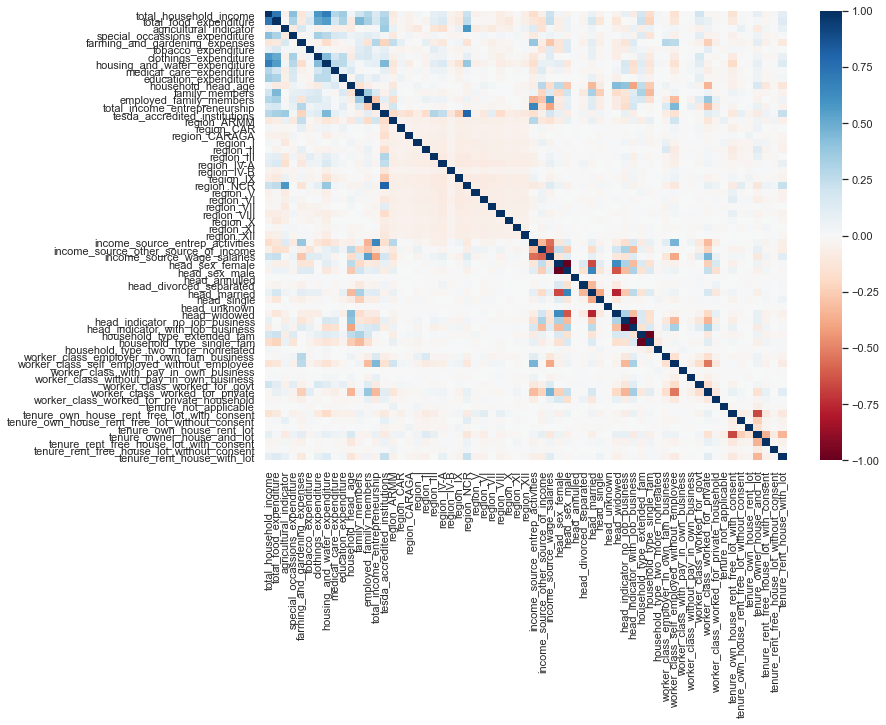

In [36]:
corr = encoded_income_df.corr()
# Make figure size larger
sns.set(rc={'figure.figsize':(11.7,8.27)})

# using seaborn to plot the correlation heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')

### multicolinearity using VFI (there are errors atm)

In [37]:
# the VFI does expect a constant term in the data, so we need to add one using the add_constant method
X1 = sm.tools.add_constant(encoded_income_df)

# create the series for before
series_before = pd.Series([variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])], index=X1.columns)

# display the series
display(series_before)

C:\Users\isabelle\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\isabelle\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


const                                         0.000000
total_household_income                        3.947197
total_food_expenditure                        3.243027
agricultural_indicator                        1.941148
special_occassions_expenditure                1.288823
                                                ...   
tenure_own_house_rent_lot                          inf
tenure_owner_house_and_lot                         inf
tenure_rent_free_house_lot_with_consent            inf
tenure_rent_free_house_lot_without_consent         inf
tenure_rent_house_with_lot                         inf
Length: 64, dtype: float64

### Sampling and creating the train and test dataset
For us to get random values we decided to used random sampling. From the random sample we will check the accuracy of the model. We used the train and test method and split the data set into two with the **ratio 30-70**, 30% for testing and 70% for training. 

After splitting the data, we will create an instance of the linear regression model and pass through the x_train and y_train variables using the fit() function.

In [370]:
sampled_income_df = encoded_income_df.sample(n=1300,random_state=1)

In [371]:
# Assign columns to X and Y
X = sampled_income_df.drop(['total_household_income'], axis = 1)
Y = sampled_income_df[['total_household_income']]

# Split X and y into X_
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=1)

In [372]:
def getScore(modelName, model):
    print(modelName)
    print("Train R-Squared: ", model.score(x_train, y_train))
    print("Test R-Squared: ", model.score(x_test, y_test))

In [373]:
# instantiate models
modelLR = LinearRegression()
modelNN = MLPRegressor()
modelRF = RandomForestRegressor()

In [374]:
modelNN.fit(x_train, y_train.values.flatten())
getScore("Multi Layer Perceptron Model", modelNN)

Multi Layer Perceptron Model
Train R-Squared:  0.7708384810367903
Test R-Squared:  0.7467196004650508


C:\Users\Cary\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [375]:
modelLR.fit(x_train, y_train.values.flatten())
getScore("Linear Regression Model", modelLR)

Linear Regression Model
Train R-Squared:  0.8108096196538319
Test R-Squared:  0.7608356546103492


In [376]:
modelRF.fit(x_train, y_train.values.flatten())
getScore("Random Forest Regression Model", modelRF)

Random Forest Regression Model
Train R-Squared:  0.9644256903854834
Test R-Squared:  0.7201948756693497


### Determining Model Accuracy
In order for us to examined how our data fits the model, we will **take predicted value and compare them to our actual value** these will be our residuals. From here we can calculate a few metrics to check how well our model fits the data. 

In [380]:
def getErrors(modelName, pred):
    print(modelName)
    e = mean_squared_error(pred, y_test)
    print("Mean Squared Error (MSE): ", e)
    print("Mean Absolute Error (MAE): ", mean_absolute_error(pred, y_test))
    print("Root Mean Squared Error (RMSE): ", math.sqrt(e))
    print()

In [381]:
LRpred = modelLR.predict(x_test)
NNpred = modelNN.predict(x_test)
RFpred = modelRF.predict(x_test)

In [382]:
getErrors("Linear Regression Model", LRpred)
getErrors("Multi Layer Perceptron Model", NNpred)
getErrors("Random Forest Regression Model", RFpred)

Linear Regression Model
Mean Squared Error (MSE):  3931676538.4450116
Mean Absolute Error (MAE):  40269.71860788302
Root Mean Squared Error (RMSE):  62703.08236797464

Multi Layer Perceptron Model
Mean Squared Error (MSE):  4163733531.756736
Mean Absolute Error (MAE):  39457.03566447571
Root Mean Squared Error (RMSE):  64526.99847162222

Random Forest Regression Model
Mean Squared Error (MSE):  4599779456.57075
Mean Absolute Error (MAE):  40592.87728205128
Root Mean Squared Error (RMSE):  67821.67394403319



### Creating the model without sampling
We also try to create the model without the random sampling to check if their is any difference compared from with sampling. Applying different methods to test the model would help us check the accuracy of our chosen models. 

In [384]:
# Assign columns to X and Y
X = encoded_income_df.drop(['total_household_income'], axis = 1)
Y = encoded_income_df[['total_household_income']]

# Split X and y into X_
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=1)

In [385]:
modelNN.fit(x_train, y_train.values.flatten())
getScore("Multi Layer Perceptron Model", modelNN)

C:\Users\Cary\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Multi Layer Perceptron Model
Train R-Squared:  0.729108447641383
Test R-Squared:  0.739906858253929


In [386]:
modelLR.fit(x_train, y_train.values.flatten())
getScore("Linear Regression Model", modelLR)

Linear Regression Model
Train R-Squared:  0.7419002601188683
Test R-Squared:  0.7576879926551849


In [387]:
modelRF.fit(x_train, y_train.values.flatten())
getScore("Random Forest Regression Model", modelRF)

Random Forest Regression Model
Train R-Squared:  0.9644211291330924
Test R-Squared:  0.7613696755347255


### Determining Model Accuracy without Sampling



In [388]:
def getErrors(modelName, pred):
    print(modelName)
    e = mean_squared_error(pred, y_test)
    print("Mean Squared Error (MSE): ", e)
    print("Mean Absolute Error (MAE): ", mean_absolute_error(pred, y_test))
    print("Root Mean Squared Error (RMSE): ", math.sqrt(e))
    print()

In [389]:
LRpred = modelLR.predict(x_test)
NNpred = modelNN.predict(x_test)
RFpred = modelRF.predict(x_test)

In [390]:
getErrors("Linear Regression Model", LRpred)
getErrors("Multi Layer Perceptron Model", NNpred)
getErrors("Random Forest Regression Model", RFpred)

Linear Regression Model
Mean Squared Error (MSE):  3472041888.579134
Mean Absolute Error (MAE):  37240.03920347442
Root Mean Squared Error (RMSE):  58924.03489730768

Multi Layer Perceptron Model
Mean Squared Error (MSE):  3726824324.4316144
Mean Absolute Error (MAE):  37490.146473209235
Root Mean Squared Error (RMSE):  61047.72169730509

Random Forest Regression Model
Mean Squared Error (MSE):  3419287766.6588
Mean Absolute Error (MAE):  35017.00678315161
Root Mean Squared Error (RMSE):  58474.676285198875



### Evaluating the Model
In evaluating the model we will used the statsmodel module. This module has built-in functions that will make calculating metrics quick. In order for us to rebuild our model we create a constant variable, call the OLS() method and then the fit() method.

In [391]:
# define our input
X2 = sm.add_constant(X)

# create a OLS model
model = sm.OLS(Y, X2)

# fit the data
est = model.fit()

### Checking for Heteroscedasticity and Autocorrelation
In order to determine if heteroscedasticity is present in our regression model we used the Breusch-Pagan test. 

In [392]:
# Run the Breusch-Pagan test
_, pval, __, f_pval = diag.het_breuschpagan(est.resid, est.model.exog)
print(pval, f_pval)
print('-'*100)

# print the results of the test
if pval > 0.05:
    print("For the Breusch-Pagan's Test")
    print("The p-value was {:.4}".format(pval))
    print("We fail to reject the null hypothesis, so there is no heterosecdasticity.")

else:
    print("For the Breusch-Pagan's Test")
    print("The p-value was {:.4}".format(pval))
    print("We reject the null hypothesis, so there is heterosecdasticity.")

0.0 0.0
----------------------------------------------------------------------------------------------------
For the Breusch-Pagan's Test
The p-value was 0.0
We reject the null hypothesis, so there is heterosecdasticity.


The number of lags will be 10
----------------------------------------------------------------------------------------------------


C:\Users\Cary\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


The lowest p-value found was 0.0
We reject the null hypothesis, so there is autocorrelation.
----------------------------------------------------------------------------------------------------


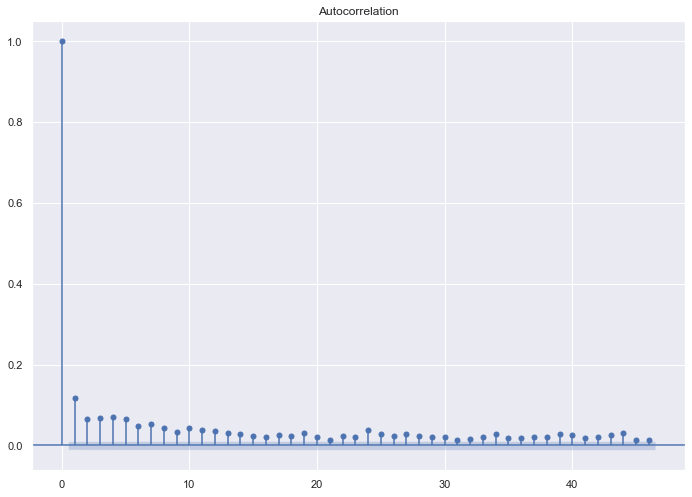

In [393]:
# calculate the lag, optional
lag = min(10, (len(X)//5))
print('The number of lags will be {}'.format(lag))
print('-'*100)

# run the Ljung-Box test for no autocorrelation of residuals
test_results = diag.acorr_ljungbox(est.resid, lags = lag)

# grab the p-values and the test statistics
ibvalue, p_val = test_results

# print the results of the test
if min(p_val) > 0.05:
    print("The lowest p-value found was {:.4}".format(min(p_val)))
    print("We fail to reject the null hypothesis, so there is no autocorrelation.")
    print('-'*100)
else:
    print("The lowest p-value found was {:.4}".format(min(p_val)))
    print("We reject the null hypothesis, so there is autocorrelation.")
    print('-'*100)

# plot autocorrelation
sm.graphics.tsa.plot_acf(est.resid)
plt.show()

NameError: name 'pylab' is not defined

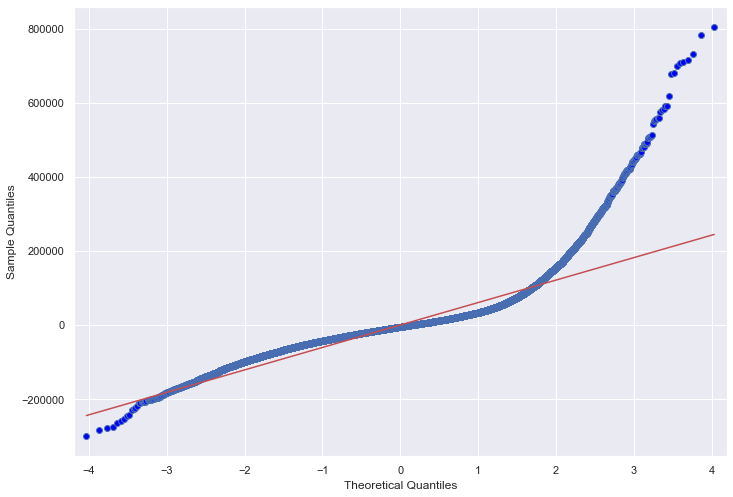

In [394]:
sm.qqplot(est.resid, line='s')
pylab.show()

# also check that the mean of the residuals is approx. 0.
mean_residuals = sum(est.resid)/ len(est.resid)
print("The mean of the residuals is {:.4}".format(mean_residuals))

In [ ]:
print(est.summary())